In [1]:
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
from IPython import display
import copy

(512, 512, 3)


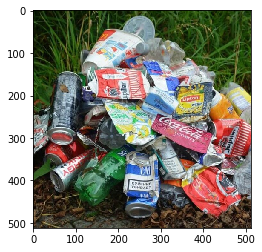

In [2]:
standard = cv2.imread('data/imgonline-com-ua-Resize-QsLYVQceGlP0h.jpg')
standard = cv2.cvtColor(standard, cv2.COLOR_BGR2RGB)
standard = standard/255.
standard = standard[:, 100:612]
print(standard.shape)
plt.imshow(standard)
plt.show()

In [11]:
class Individ:
                      
    def __init__(self, standard):
        self.type = random.randint(0, 1) # 0 = \, 1 =/
        self.shape = standard.shape
        x = random.choice([1, -1])
        y = random.choice([1, -1])
        
        if self.type == 1:
            self.color1 = np.mean(standard[0:self.shape[0]//2, 0:self.shape[1]//2,:], axis=(0,1))
            self.color2 = np.mean(standard[self.shape[0]//2:, self.shape[1]//2:,:], axis=(0,1))    
        else:
            self.color1 = np.mean(standard[0:self.shape[0]//2, self.shape[1]//2:,:], axis=(0,1))
            self.color2 = np.mean(standard[self.shape[0]//2:, :self.shape[1]//2,:], axis=(0,1))
            
        x = random.choice([1, -1])
        y = random.choice([1, -1])
        if x == 1:
            self.color1 = self.color1*0.7 + np.random.rand(3)*0.3
        else:
            self.color1 = abs(self.color1*0.7 - np.random.rand(3)*0.3)
        if y == 1:
            self.color2 = self.color2*0.7 + np.random.rand(3)*0.3
        else:
            self.color2 = abs(self.color2*0.7 - np.random.rand(3)*0.3)
        
        self.changed = True
    
    def render(self):
        tmp = np.zeros(self.shape)
        if (self.type == 0):
            tmp = cv2.fillPoly(tmp, [np.array([[0, 0], [self.shape[0]-1, self.shape[1]-1], [self.shape[0]-1, 0]])], tuple(self.color1))
            tmp = cv2.fillPoly(tmp, [np.array([[0, 0], [self.shape[0]-1, self.shape[1]-1], [0, self.shape[1]-1]])], tuple(self.color2))
        else:
            tmp = cv2.fillPoly(tmp, [np.array([[0, self.shape[1]-1], [self.shape[0]-1, self.shape[1]-1], [self.shape[0]-1, 0]])], tuple(self.color1))
            tmp = cv2.fillPoly(tmp, [np.array([[self.shape[0]-1, 0], [0, 0], [0, self.shape[1]-1]])], tuple(self.color2))
            
        self.image = tmp
        self.changed = False
    
    def get_image(self):
        if self.changed:
            self.render()
        return self.image
    
    def mutate(self, flag):
        self.changed = True
        if flag == 0:
            self.color1, self.color2 = self.color2, self.color1
        elif flag == 1:
            self.type = abs(self.type - 1)
        self.color1 = np.abs(self.color1*0.9 + np.random.rand(3)*0.1*random.choice([1, -1]))
        self.color2 = np.abs(self.color2*0.9 + np.random.rand(3)*0.1*random.choice([1, -1]))       

In [12]:
class Population:
    def __init__(self, ind_numb, standard_part):
        self.ind_numb = ind_numb
        self.standard_part = standard_part
        self.individs = [Individ(self.standard_part) for x in range(ind_numb)]
            
    def mutate(self, _mutants):
        mutants = copy.deepcopy(_mutants)
        for i in mutants:
            flag = random.randint(0, 1)
            i.mutate(flag)
        return mutants
    
    def next_generation(self):        
        mutants = self.mutate(np.random.choice(self.individs, self.ind_numb//3))
        self.individs = self.sort_errors(np.concatenate((self.individs, mutants)))[:self.ind_numb]
        
    def count_errors(self, arr):
        return [np.sum((self.standard_part - i.get_image())**2) for i in  arr]
        
    def sort_errors(self, arr):
        errors = self.count_errors(arr)
        for i in range(len(arr) - 1):
            for k in range(len(arr) - 1 - i):
                if errors[k] > errors[k+1]:
                    errors[k], errors[k+1] = errors[k+1], errors[k]
                    arr[k], arr[k+1] = arr[k+1], arr[k]
        self.best_err = errors[0]
        return arr
                    
    def get_best(self):
        return self.individs[0]

In [13]:
print(standard.shape)
new = np.zeros(standard.shape)

def gen_picture(standard, size):
    for i in range(0, standard.shape[0],size):
        for j in range(0, standard.shape[0],size):
            a = Population(20, standard[i:i+size, j:j+size, :])
            a.next_generation()
            best = a.get_best()
            best_err =  a.best_err
            history = []
            for k in range(50):
                a.next_generation()
                if a.best_err < best_err:
                    best = a.get_best()
                    best_err = a.best_err
            new[i:i+size, j:j+size, :] = copy.deepcopy(best.get_image())
            plt.imshow(new)
            plt.show()
            display.clear_output(wait=True)


            

(512, 512, 3)


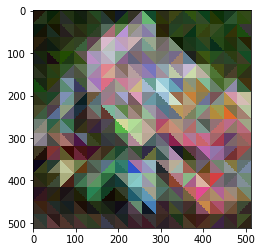

In [14]:
gen_picture(standard, 32)

cv2.imwrite('data/rubbish_8.png', (new*255).astype(np.uint8)[...,::-1])

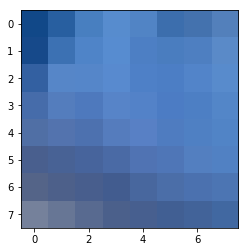

In [15]:
mini = standard[230:238, 302:310, :]
plt.imshow(mini)

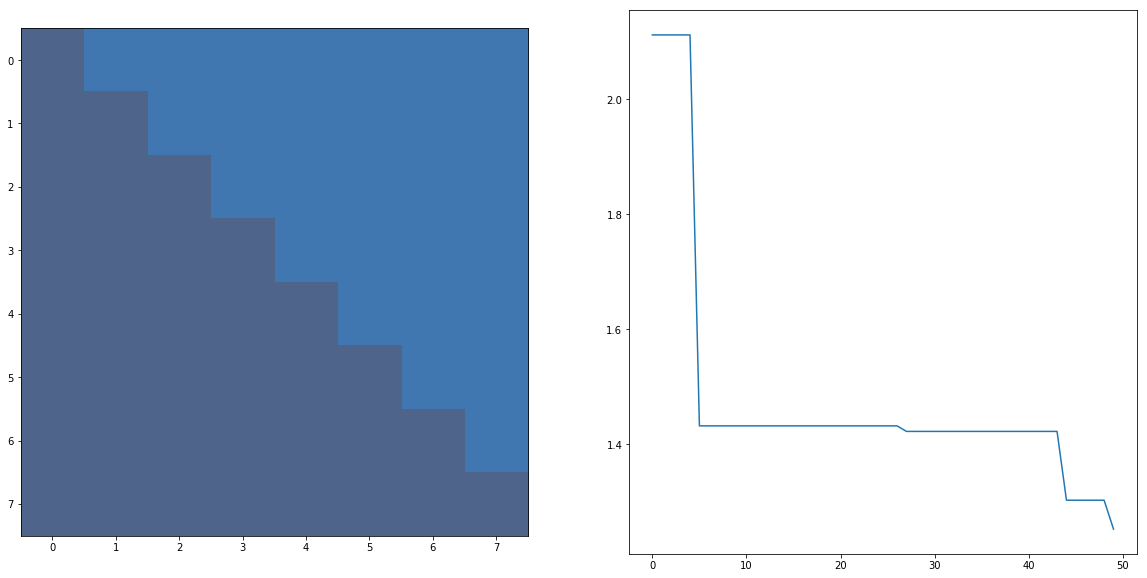

In [22]:
a = Population(20,mini)
a.next_generation()
best = a.get_best()
best_err =  a.best_err
history = []
for i in range(50):
    a.next_generation()
    if a.best_err < best_err:
        best = a.get_best()
        best_err = a.best_err
        
    history.append(a.best_err)
    fig = plt.figure(figsize=(20,10))
    fig.add_subplot(1,2,1)
    plt.imshow(best.get_image())
    fig.add_subplot(1,2,2)
    plt.plot(history)
    plt.show()
    display.clear_output(wait=True)